## Imports

In [1]:
import numpy as np
import pandas as pd
import joblib, pickle
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import FunctionTransformer, Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploration

Here we perform preliminary reconnaissance on the dataset: first, `df.shape`, `df.info()` and `df.head()` provide the size (rows × columns), structure and field types, respectively, as well as a sample of the first observations, useful for discovering format inconsistencies at a glance. The second block, `df.describe().T`, summarises the descriptive statistics (count, mean, deviation, quartiles) of each numeric variable, allowing you to evaluate orders of magnitude, variability and potential outliers. The last group checks the quality of the data: sorting missing values with `df.isna().sum()` highlights the most deficient attributes, while `df.duplicated().sum()` returns **0**, guaranteeing that there are no duplicate records. Together, these commands provide a compact but comprehensive picture of the “health” of the dataset before proceeding with more sophisticated analyses.

In [2]:
df = pd.read_csv('../assets/Dataset3.csv', sep=';')

In [3]:
df.shape
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [7]:
df.isna().sum().sort_values(ascending=False)
df.duplicated().sum()

np.int64(0)

Now we perform a double inspection on *non-standardised* linear relationships. First: we select all numerical features (excluding ID and target), calculate the complete covariance matrix and provide both a tabular extract and a triangular heat map. Here, covariances in the order of 10⁹ between `LIMIT_BAL` and the six `BILL_AMT*` stand out, and within 10⁸ between the same monthly amounts: the bright red colour reflects only the magnitude of the sums managed, not the "pure" strength of the link. The small-scale variables (`SEX`, `MARRIAGE`, `PAY_*`) remain pale, even though they may be relevant, confirming that covariance is scale-dependent and should be interpreted with caution (ideally after z-score or with correlation).

Then the calculation is repeated on a targeted subset (maximum, age, first two balances and related payments). The colour contrast reiterates that the strong co-variation is concentrated between maximum and debts (`BILL_AMT*`), while the amounts paid (`PAY_AMT*`) covary much less and age is almost neutral. In practice, the full section locates the "hot spots" in the entire dataset. The reduced section puts them under the microscope, showing how much the monetary scale dominates the covariance structure and suggesting the need to standardise before PCA or models sensitive to absolute magnitudes.

In [9]:
num_cols = df.select_dtypes(include=[np.number]).columns.drop(
    ["ID", "default.payment.next.month"]
)
df_num = df[num_cols]
cov_mat = df_num.cov()
cov_mat.iloc[:6, :6]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
LIMIT_BAL,1.683446e+10,1571.050630,-22474.028945,-7323.669658,173076.722569,-39545.930009
SEX,1.571051e+03,0.239247,0.005502,-0.008014,-0.409726,-0.031685
EDUCATION,-2.247403e+04,0.005502,0.624651,-0.059184,1.275380,0.093584
MARRIAGE,-7.323670e+03,-0.008014,-0.059184,0.272452,-1.992764,0.011683
AGE,1.730767e+05,-0.409726,1.275380,-1.992764,84.969755,-0.408639
PAY_0,-3.954593e+04,-0.031685,0.093584,0.011683,-0.408639,1.262930


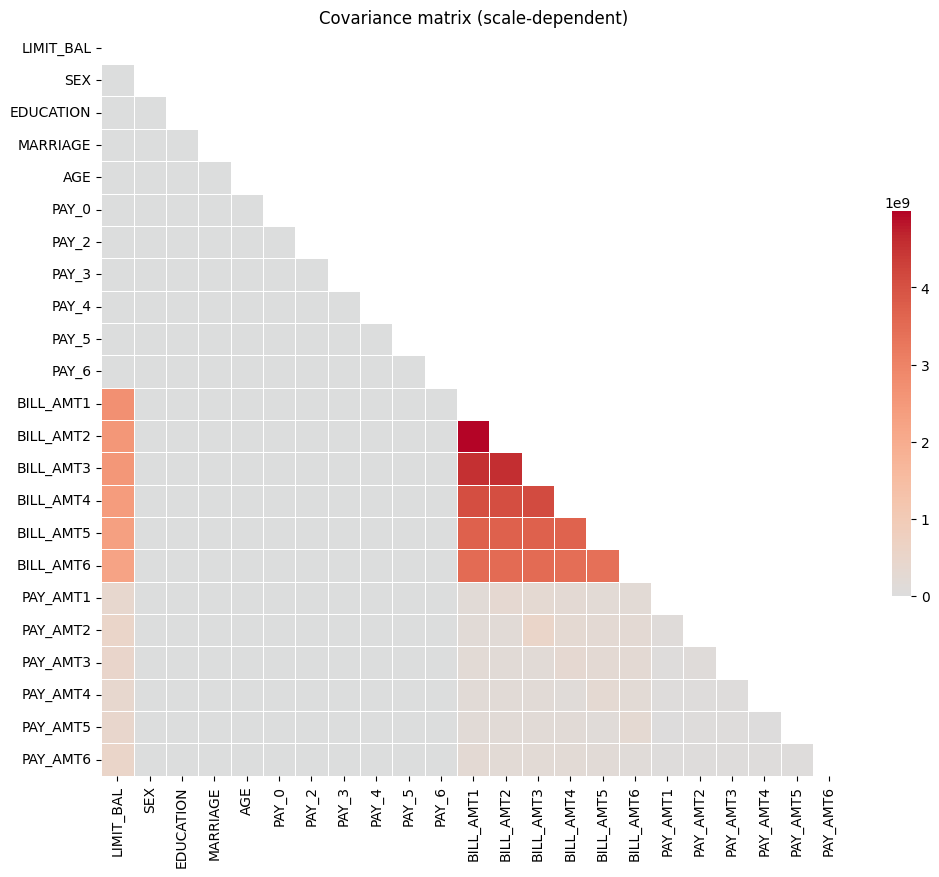

In [11]:
plt.figure(figsize=(12,10))
mask = np.triu(np.ones_like(cov_mat, dtype=bool))
sns.heatmap(
    cov_mat, mask=mask, cmap="coolwarm", center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5}
)
plt.title("Covariance matrix (scale-dependent)")
plt.show()

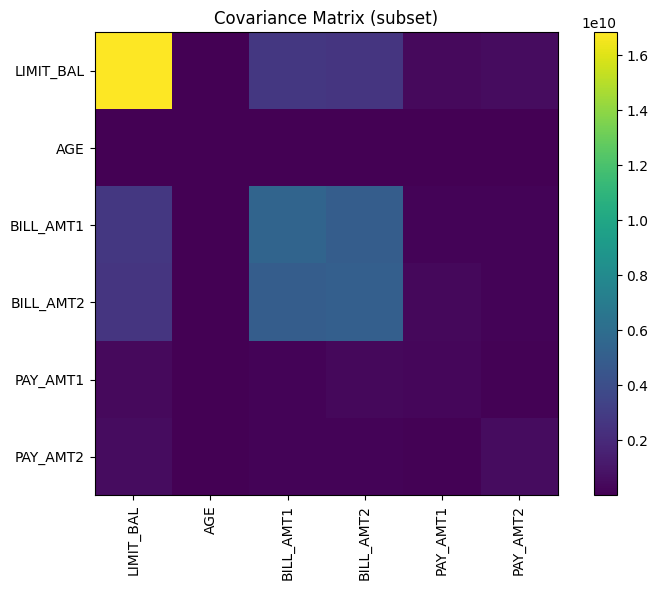

In [12]:
subset_cols = ["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2",
               "PAY_AMT1", "PAY_AMT2"]
cov_subset = df[subset_cols].cov()

plt.figure(figsize=(8, 6))
plt.imshow(cov_subset, interpolation="none")
plt.title("Covariance Matrix (subset)")
plt.xticks(range(len(subset_cols)), subset_cols, rotation=90)
plt.yticks(range(len(subset_cols)), subset_cols)
plt.colorbar()
plt.tight_layout()
plt.show()


The frequency graph highlights a marked **class asymmetry**: cases of non-default (≈ 23 k, 78%) exceed those of default (≈ 6 k, 22%) by more than three times. This disproportion, while not extreme, is sufficient to skew a "naive" classifier towards the majority: high apparent accuracy but poor ability to detect defaults. In view of modelling, it will therefore be necessary to adopt measures, minority-sensitive metrics (ROC-AUC, recall, F1-score), rebalancing techniques (weighting, oversampling/SMOTE) or calibrated decision thresholds, to prevent the algorithm from minimising the most costly errors for credit.

C:\Users\antoj\AppData\Local\Temp\ipykernel_33456\1937499963.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No default", "Default"])


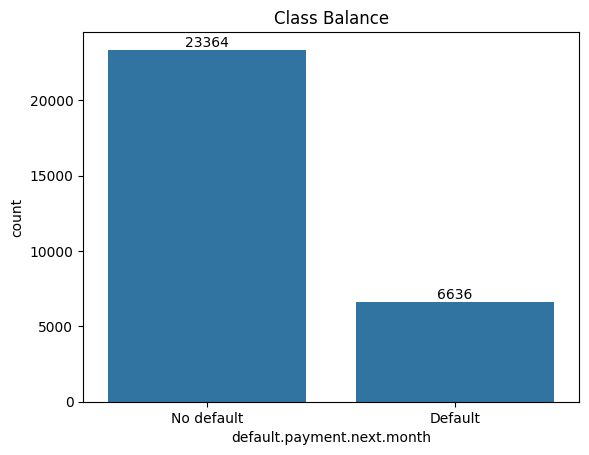

In [13]:
ax = sns.countplot(x="default.payment.next.month", data=df)
ax.bar_label(ax.containers[0], fmt="%.0f")
ax.set_xticklabels(["No default", "Default"])
ax.set_title("Class Balance")
plt.show()

The triangular heat map summarises the Pearson correlation (already adjusted for the different scales) between all variables, excluding ID. Three distinct blocks emerge:
1. Strong positive collinearity between the six billing amounts (`BILL_AMT*`), almost mirroring that seen in covariance but now "pure" (ρ ≈ 0.85-0.95);
2. An equally compact cluster between the repayment statuses `PAY_1-PAY_6`, with ρ > 0.7, which indicates information redundancy and possible multicollinearity in the models;
3. Moderate and **opposite** links between `LIMIT_BAL` and insolvency indicators (`PAY_*`, target included): high credit limits tend to correlate weakly (ρ ≈ -0.2) with default.

The target `default.payment.next.month` shows the highest (albeit modest) positive correlation with `PAY_0`-`PAY_2` (ρ ≈ 0.24-0.30), confirming that recent delays are the most predictive signal, while age, gender and education remain almost neutral (|ρ| < 0.05). From a modelling perspective: it is useful to evaluate feature selection or dimensional reduction techniques for highly collinear blocks and, above all, to give weight to payment delays, while bearing in mind that no single predictor exceeds the threshold of 0.3 correlation with the default event.

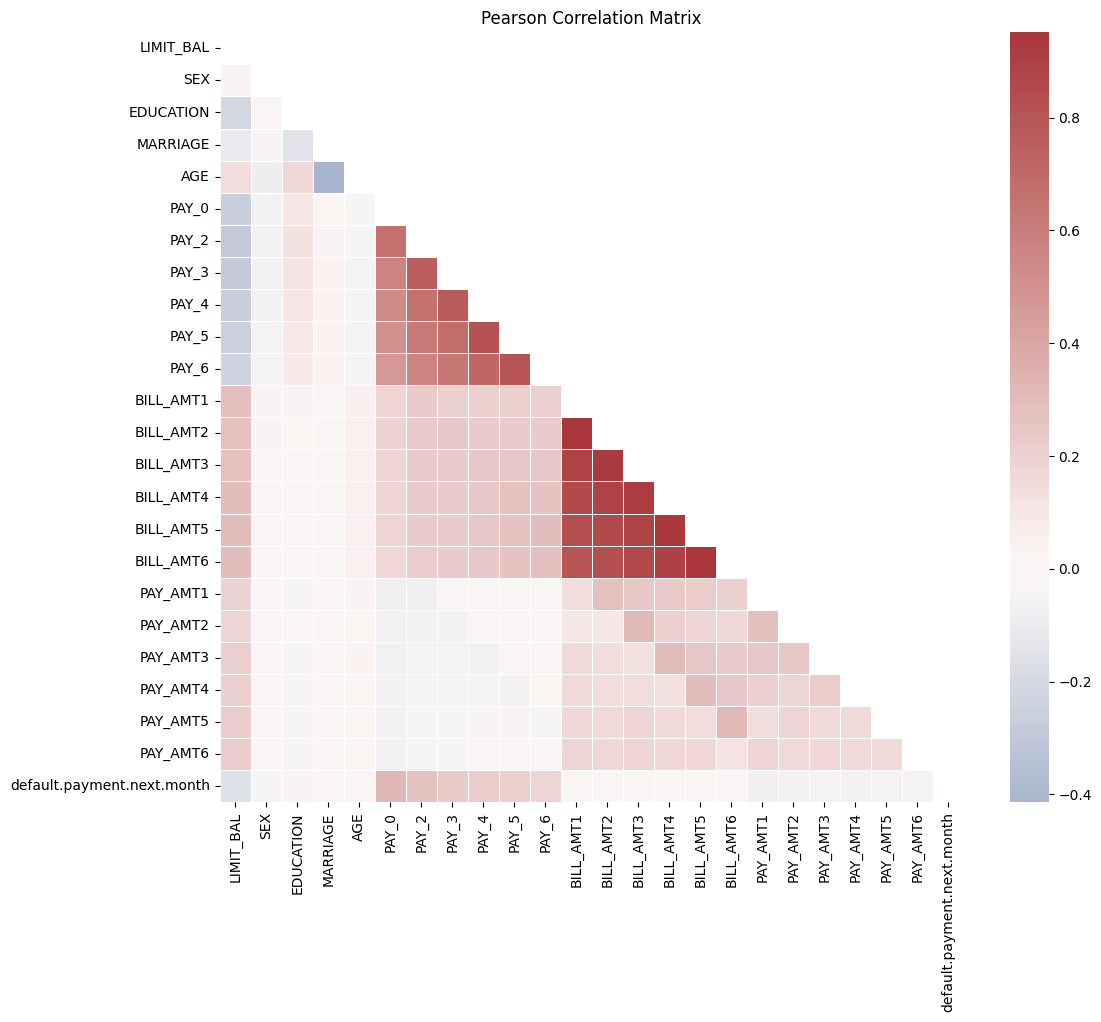

In [14]:
corr = df.drop(columns=["ID"]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, cmap="vlag", center=0, linewidths=.5)
plt.title("Pearson Correlation Matrix")
plt.show()


Here we calculate a normalised crosstab row by row and draws a stacked bar plot: for each level of **EDUCATION**, it shows the percentage of "Default" versus "No default" customers. Two anomalies immediately catch the eye: level 0 (missing/unknown value) has no defaults, probably due to a small sample size, while levels 4-5 have the lowest default rate (≈ 5-8%), suggesting a protective effect of advanced education. The intermediate levels 1-3, on the other hand, fluctuate around 20-25%, in line with the average rate of the dataset, and level 6 rises to \~15%. The graph therefore confirms that education is only **moderately discriminating** with respect to default and that some categories (0, 6) should perhaps be recoded or aggregated to avoid noise in the models.

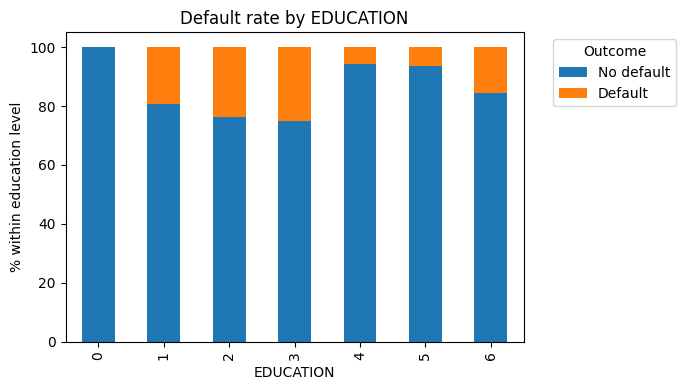

In [15]:
ct = pd.crosstab(df["EDUCATION"], df["default.payment.next.month"],
                 normalize="index") * 100  # percentuale riga
ct.plot(kind="bar", stacked=True, figsize=(7,4))
plt.legend(["No default", "Default"], title="Outcome", bbox_to_anchor=(1.05,1))
plt.ylabel("% within education level")
plt.title("Default rate by EDUCATION")
plt.tight_layout()
plt.show()


The double violin/box plot reveals a **highly asymmetrical credit pattern** for all education levels: long tails towards the top and numerous outliers (up to 1 M¥) indicate that few customers obtain exceptional credit limits, while the majority are concentrated below 300 k. The medians show a moderate deviation: graduates (1) and levels 4-5 typically enjoy a higher limit (\~200-220 k) than other groups, but the distributions overlap widely, indicating that education alone explains only a fraction of the variability in `LIMIT_BAL`. Level 0 (unknown) appears lower and more volatile, confirming the suspected statistical fragility of this category.

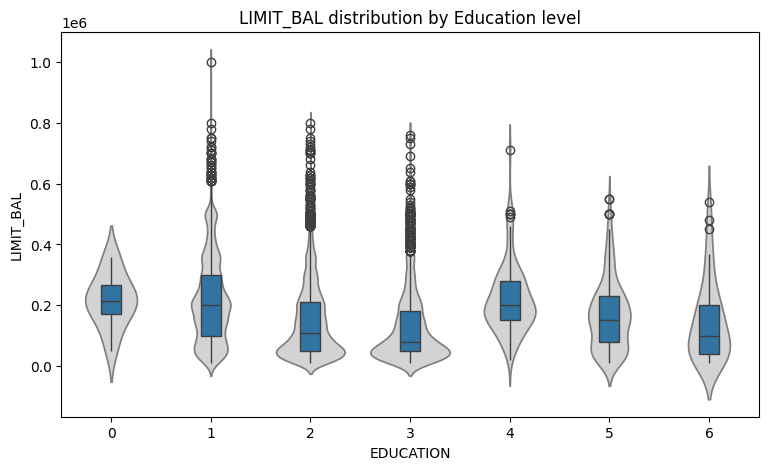

In [16]:
plt.figure(figsize=(9,5))
sns.violinplot(x="EDUCATION", y="LIMIT_BAL", data=df, inner=None, color="lightgray")
sns.boxplot   (x="EDUCATION", y="LIMIT_BAL", data=df, width=0.2, showcaps=False)
plt.title("LIMIT_BAL distribution by Education level")
plt.show()


Here we draw two independent **kernel density estimates** (`common_norm=False`) of age, filled and superimposed by default (orange) and non-default (blue). The peak in both cases falls between 28 and 32 years of age, with almost mirror-image curves: the default line is slightly wider in the tail < 28 and over 45 years of age, indicating a slight over-representation of younger and mature customers among insolvent customers, but the shared area is predominant. So, the **AGE variable alone has little discriminatory power**: any model that includes it will have to capture non-linear effects or interactions (e.g. age × payment status) to extract a signal, otherwise it risks adding only noise.

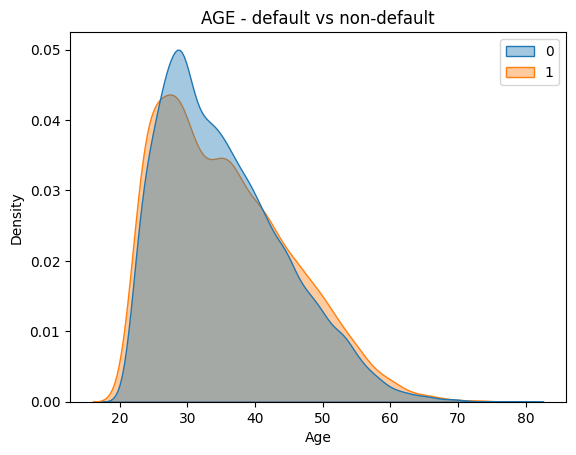

In [17]:
g = sns.kdeplot(data=df, x="AGE", hue="default.payment.next.month",
                fill=True, common_norm=False, alpha=.4)
g.set_xlabel("Age"); g.set_title("AGE - default vs non-default")
g.legend_.set_title("")
plt.show()


The violin plot of **PAY\_0** highlights a clear difference between classes: customers without defaults cluster around values of -1/0 (on-time or slightly early payment), with very rare delays ≥1; among defaults, on the other hand, the distribution is shifted upwards, with a median around 2 and a tail reaching 8 months of arrears. The asymmetry suggests that the current delinquency status is the most powerful single predictor, but it also signals a potential target leakage: if the model “sees” the delay in the current month while it has to predict insolvency in the following month, it risks learning an almost tautological correlation. It is therefore necessary to assess whether to exclude PAY\_0 or shift it temporally to maintain a genuinely forward-looking forecast.

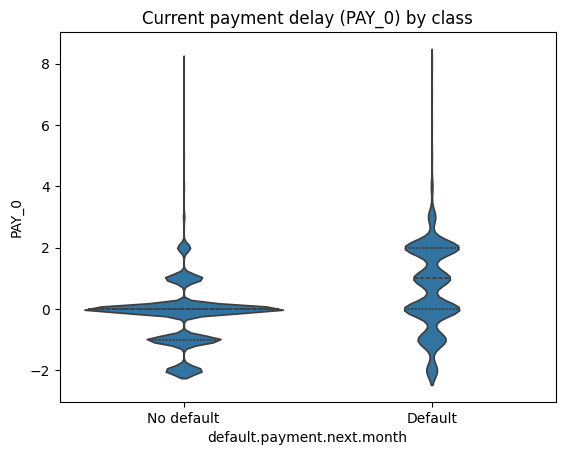

In [18]:
sns.violinplot(x="default.payment.next.month", y="PAY_0", data=df, inner="quartile")
plt.xticks([0,1], ["No default", "Default"])
plt.title("Current payment delay (PAY_0) by class")
plt.show()


The pairplot provides a quick bivariate overview of LIMIT_BAL, AGE, PAY_0 and the first billed balance BILL_AMT1, encoding the target with different colours. The figure consolidates the highlights that emerged individually:
1. `PAY_0` is the real discriminant;
2. The two monetary amounts are almost collinear and capture the same exposure dynamic;
3. Age remains marginal.

An excellent exploratory tool, but beware of multicollinearity `LIMIT_BAL <=> BILL_AMT1` and the risk of data leakage if `PAY_0` is contemporary with the forecast period.

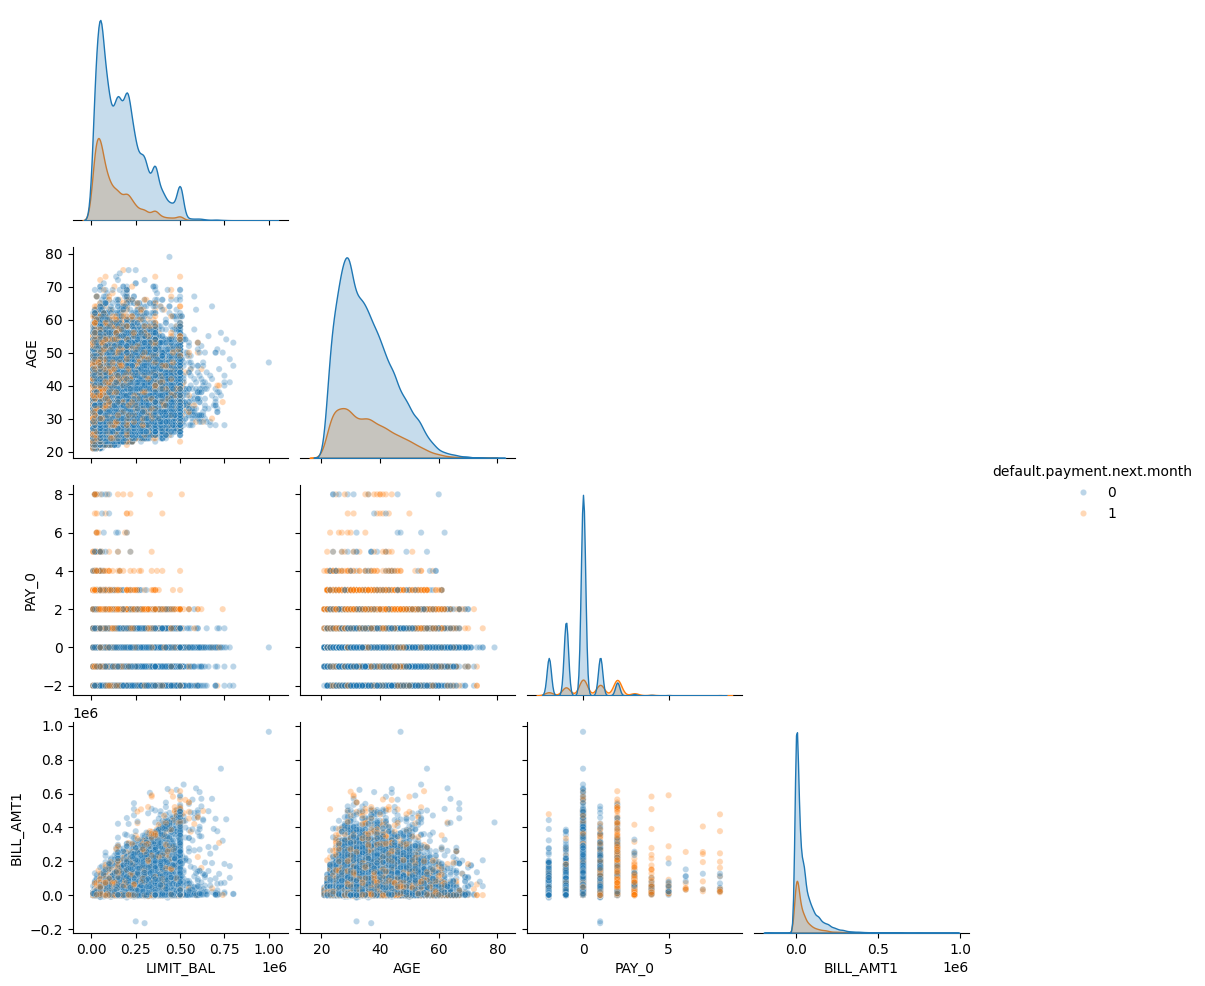

In [19]:
top_vars = ["LIMIT_BAL", "AGE", "PAY_0", "BILL_AMT1", "default.payment.next.month"]
sns.pairplot(df[top_vars], hue="default.payment.next.month", corner=True,
             plot_kws=dict(alpha=.3, s=20))
plt.show()


Here we calculate the covariance (still scale-dependent) for each monthly pair `BILL_AMT m`-`PAY_AMT m` and plot its trend: the decreasing sequence from ≈ 1.7 × 10⁸ (M1) to 1.2 × 10⁸ (M6) indicates that, month after month, the linear relationship between what is charged and what is actually repaid weakens. The sharp jump between M3 and M4 is a warning sign: starting from the fourth billing cycle, payments stop growing proportionally to balances, a typical prelude to the accumulation of arrears. However, since covariance is sensitive to monetary units, the comparison of “strength” should be confirmed with Pearson's correlation or prior standardisation; otherwise, variations in the order of magnitude of the balances could mask or inflate the real phenomenon.

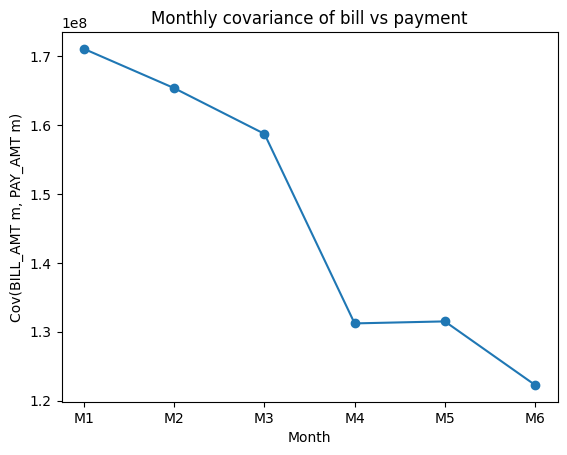

In [20]:
months = range(1,7)
cov_values = [df[f"BILL_AMT{m}"].cov(df[f"PAY_AMT{m}"]) for m in months]

plt.plot(months, cov_values, marker="o")
plt.xticks(months, [f"M{m}" for m in months])
plt.ylabel("Cov(BILL_AMT m, PAY_AMT m)")
plt.xlabel("Month")
plt.title("Monthly covariance of bill vs payment")
plt.show()

This scatterplot crosses the balance of the 5th month (`BILL_AMT5`) with that of the 6th (`BILL_AMT6`), distinguishing between defaulting customers (orange) and non-defaulting customers (blue) and superimposing an OLS regression line. The compact cloud along the diagonal confirms an almost linear persistence of debts from one billing cycle to the next (ρ ≈ 0.95): those who are exposed in M5 tend to remain exposed in M6. Insolvent customers do not visibly deviate from the central trend: the orange colour is distributed across the entire range and only slightly denser in the upper quadrants, a sign that a simple comparison of consecutive balances **does not effectively discriminate the outcome of default**. There are rare outliers (negative amounts or amounts over 800 k) that could reflect repayments/accounting exceptions and deserve cleaning or winsorisation.

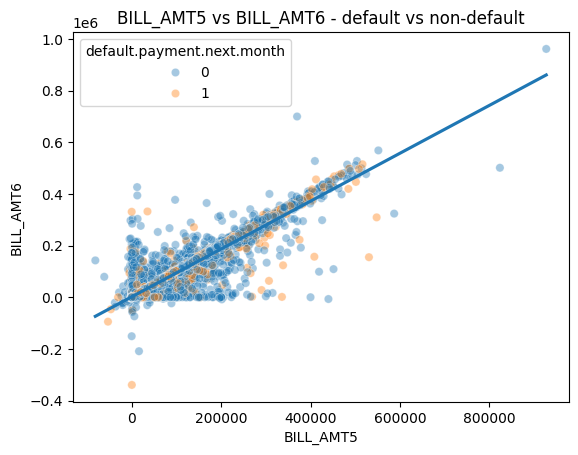

In [21]:
sns.scatterplot(data=df, x="BILL_AMT5", y="BILL_AMT6",
                hue="default.payment.next.month", alpha=.4)
sns.regplot(data=df, x="BILL_AMT5", y="BILL_AMT6",
            scatter=False, ci=None)
plt.title("BILL_AMT5 vs BILL_AMT6 - default vs non-default")
plt.show()

The box plot compares the credit limit (`LIMIT_BAL`) between defaulting and non-defaulting customers: the median for defaulters is approximately 50-60 k lower than for regular payers, and the entire interquartile range is shifted downwards, indicating that more modest limits are slightly more exposed to risk. However, the overlap between the “boxes” remains large, with more than half of the distributions coinciding, and there appears to be a large number of high outliers, especially in the non-default class (up to 1 M¥), which reveals that a high limit does not in itself imply insolvency but amplifies the variance. So, `LIMIT_BAL` has only marginal discriminatory power: useful as a context variable but not to be overestimated without cross-referencing it with payment behaviour and income capacity.

C:\Users\antoj\AppData\Local\Temp\ipykernel_33456\2688829509.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([default0, default1],


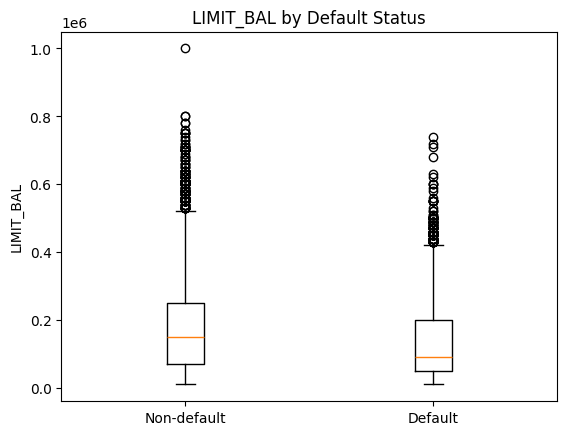

In [22]:
default0 = df[df["default.payment.next.month"] == 0]["LIMIT_BAL"]
default1 = df[df["default.payment.next.month"] == 1]["LIMIT_BAL"]

plt.figure()
plt.boxplot([default0, default1],
            labels=["Non-default", "Default"])
plt.title("LIMIT_BAL by Default Status")
plt.ylabel("LIMIT_BAL")
plt.show()


## Data Loading

Here we set a folder for saving trained models, build the feature matrix by dropping the non-informative ID and the target column, earmarks categorical attributes and selected repayment-status fields for later preprocessing, and then create a reproducible 80/20 train-test.

In [23]:
MODEL_DIR = Path("./assets/models")

X = df.drop(['ID', 'default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

dummy_cols = ['SEX', 'EDUCATION', 'MARRIAGE']  # categorical features
pay_cols = [f'PAY_{i}' for i in [0, 2, 3, 4, 5, 6]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#### Definition of preprocessing pipelines

With these blocks we set up the numerical-feature preprocessing strategy for the forthcoming model: we first craft a **signed log transform** to tame heavy-tailed positives and negatives. Then we declare the set of highly skewed "BILL\_AMT" and "PAY\_AMT" variables targeted for that treatment. Finally we assemble two pipelines-one for those skewed amounts (impute missing values with 0 -> apply the signed log -> robust-scale to kill remaining outliers) and one for the more regular ordinal features (impute with the mode -> standard-scale). In short, we are laying down clean, robust numeric inputs before any learning algorithm ever sees the data.


In [24]:
def signed_log_transform(X):
    """
    Apply signed log transformation to the input data.
    """
    return np.sign(X) * np.log1p(np.abs(X))

In [25]:
skew_feats = [f'BILL_AMT{i}' for i in range(1, 7)] + \
             [f'PAY_AMT{i}'  for i in range(1, 7)]

# Pipeline: impute 0 → log1p → RobustScaler
skew_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('log', FunctionTransformer(func=signed_log_transform, feature_names_out='one-to-one')),
    ('rscale', RobustScaler())
])

ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

## Evaluation Functions

With this block we equip ourselves with a mini "assessment lab" for any classifier we train: we first define `evaluate`, which lets us audit the model on both train and test splits in one call, reporting a full slate of threshold-based metrics (accuracy, precision, recall, F1) plus probability-based AUC. We add `evaluate_balanced` to focus on class-imbalance balanced accuracy and the area under the precision-recall curve, useful when defaults are rare.<br>
Finally, the two `plot_*` helpers draw the precision-recall and ROC curves, giving us visual feedback on the trade-off between false alarms and missed defaults. In short, this code sets up a repeatable, data-rich way for us to judge whether our model genuinely generalises and how it behaves across different operating points.


In [26]:
def evaluate(model, X_tr, X_te, y_tr, y_te, label):
    print("\n" + "=" * 30, label, "=" * 30)
    for split, (X_split, y_split) in (("Train", (X_tr, y_tr)),
                                      ("Test",  (X_te, y_te))):
        y_pred = model.predict(X_split)
        y_prob = model.predict_proba(X_split)[:, 1]
        print(f"[{split}] "
              f"Accuracy={accuracy_score(y_split, y_pred):.3f} | "
              f"Precision={precision_score(y_split, y_pred):.3f} | "
              f"Recall={recall_score(y_split, y_pred):.3f} | "
              f"F1={f1_score(y_split, y_pred):.3f} | "
              f"AUC={roc_auc_score(y_split, y_prob):.3f}")
    print("\nConfusion matrix (Test):")
    print(confusion_matrix(y_te, model.predict(X_te)))
    print("\nClassification report (Test):")
    print(classification_report(y_te, model.predict(X_te), digits=3))

def evaluate_balanced(model, X, y, label="Test"):
    """
    Print Balanced-Accuracy e PR-AUC (media precision-recall area).
    """
    y_pred  = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    bal_acc = balanced_accuracy_score(y, y_pred)
    pr_auc  = average_precision_score(y, y_proba)

    print(f"[{label}] Balanced-Acc={bal_acc:.3f} | PR-AUC={pr_auc:.3f}")

def plot_pr_auc(model, X, y, label="Test"):
    y_proba = model.predict_proba(X)[:, 1]
    pr_auc = average_precision_score(y, y_proba)
    precision, recall, _ = precision_recall_curve(y, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='PR Curve')
    plt.title(f'Precision-Recall Curve ({label}) - PR AUC: {pr_auc:.3f}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()

# plot auc-roc
def plot_auc_roc(model, X, y, label="Test"):
    y_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.title(f'ROC Curve ({label})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()



## Complete pipeline: Random Forest with all features

With this cell we run a **complete modeling cycle** for the credit-default task.<br>
First, we spell out how each group of features will be cleaned and scaled, then bundle those transformations into a single `ColumnTransformer`. Next, we nest that pre-processor inside a `RandomForestClassifier` and launch a **randomized hyper-parameter search** over 50 candidate forests, using 5-fold **stratified CV** and the **average-precision score** (PR-AUC) as the objective, exactly the metric we care about when the positive class is scarce. Once the search locks onto the most promising parameter set, we **refit the best model on the whole training split**, report the chosen hyper-parameters, and subject the final estimator to a battery of quantitative checks (accuracy, F1, balanced accuracy, PR-AUC) plus diagnostic plots of the PR and ROC curves. In short, this code moves us from raw, heterogeneous features to a fully tuned, performance-vetted Random Forest ready for deployment or further comparison.


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:
{'rf__n_estimators': 500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 20, 'rf__max_samples': None, 'rf__max_features': 0.5, 'rf__max_depth': 15, 'rf__class_weight': 'balanced'}

============================== Random Forest - ALL features ==============================
[Train] Accuracy=0.831 | Precision=0.602 | Recall=0.699 | F1=0.647 | AUC=0.901
[Test] Accuracy=0.789 | Precision=0.521 | Recall=0.585 | F1=0.551 | AUC=0.774

Confusion matrix (Test):
[[3959  714]
 [ 551  776]]

Classification report (Test):
              precision    recall  f1-score   support

           0      0.878     0.847     0.862      4673
           1      0.521     0.585     0.551      1327

    accuracy                          0.789      6000
   macro avg      0.699     0.716     0.707      6000
weighted avg      0.799     0.789     0.793      6000

[Test] Balanced-Acc=0.716 | PR-AUC=0.550


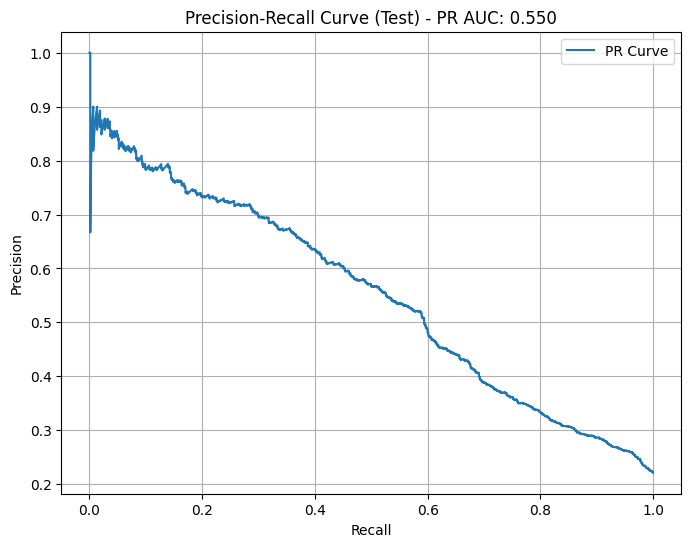

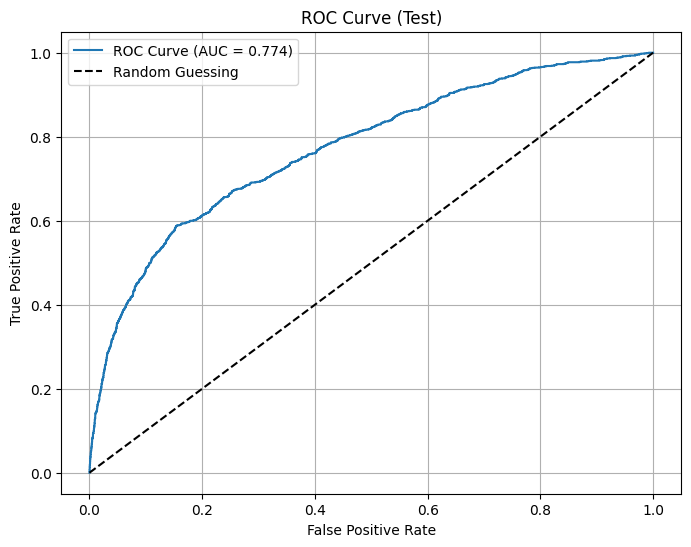

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Feature definition
categorical_features = dummy_cols
numeric_features = [c for c in X_train.columns if c not in categorical_features]

# Subset of numeric features that are not skewed that will be standardized
numeric_other = [c for c in numeric_features if c not in skew_feats + pay_cols]


preprocessor = ColumnTransformer([
    ('skew', skew_pipe, skew_feats),
    ('num', StandardScaler(), numeric_other),
    ('ord', ordinal_pipe, pay_cols),
    ('cat', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse_output=False,
        min_frequency=2
    ), categorical_features)
])

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('rf', rf_base)
])

param_dist = {
    "rf__n_estimators": list(range(400, 1001, 100)),
    "rf__max_depth":    [None, 15, 20, 25, 30],
    "rf__max_features": ["sqrt", "log2", 0.5, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf":  [5, 10, 20],
    "rf__class_weight":  ["balanced", "balanced_subsample"],
    "rf__max_samples":   [None, 0.8, 0.6]
}

rf_search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

print("Best parameters found:")
print(rf_search.best_params_)

evaluate(best_rf, X_train, X_test, y_train, y_test,
         label="Random Forest - ALL features")
evaluate_balanced(best_rf, X_test, y_test)
plot_pr_auc(best_rf, X_test, y_test, label="Test")
plot_auc_roc(best_rf, X_test, y_test, label="Test")

## Complete pipeline: Random Forest with Lasso feature selection

With this block we **shrink the feature space and fine-tune a new Random Forest in one shot**: we prepend the previous preprocessing to an L1-penalised logistic model that keeps roughly half the variables (lasso selection), pipe the surviving columns into a forest, and grid-search both the lasso strength and the forest’s main hyper-parameters under 5-fold stratified CV, optimising PR-AUC.  After refitting the best combo on the full training split, we list the features that survived the lasso, then judge the final model on hold-out data with the same metric suite and the accompanying PR and ROC curves, confirming that a leaner, more interpretable feature set attains virtually the same predictive quality (PR-AUC ≈ 0.55, ROC-AUC ≈ 0.78) as the full model.

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Feature selected: ['skew__BILL_AMT1' 'skew__PAY_AMT1' 'skew__PAY_AMT2' 'skew__PAY_AMT3'
 'skew__PAY_AMT4' 'skew__PAY_AMT6' 'num__LIMIT_BAL' 'num__AGE'
 'ord__PAY_0' 'ord__PAY_2' 'ord__PAY_3' 'ord__PAY_4' 'ord__PAY_5'
 'ord__PAY_6' 'cat__MARRIAGE_1']
Best parameters found:
{'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 600, 'sel__estimator__C': np.float64(0.01)}

============================== Random Forest - after Lasso ==============================
[Train] Accuracy=0.828 | Precision=0.596 | Recall=0.691 | F1=0.640 | AUC=0.896
[Test] Accuracy=0.788 | Precision=0.520 | Recall=0.580 | F1=0.548 | AUC=0.776

Confusion matrix (Test):
[[3962  711]
 [ 558  769]]

Classification report (Test):
              precision    recall  f1-score   support

           0      0.877     0.848     0.862      4673
           1      0.520     0.580     0.548      1327

    accuracy              

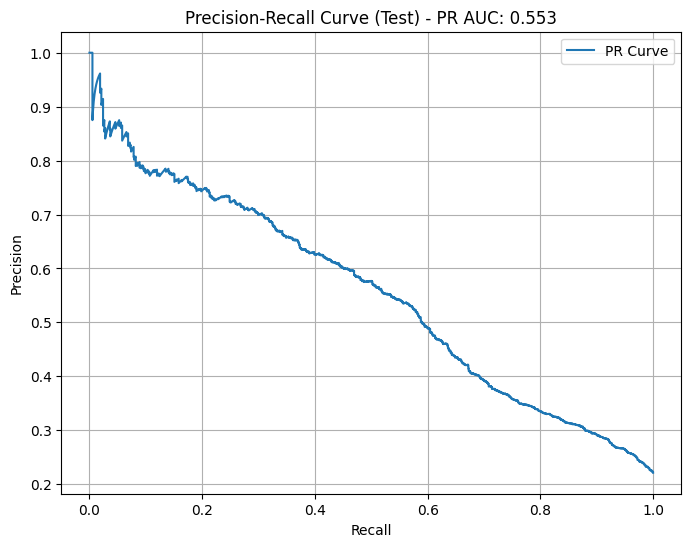

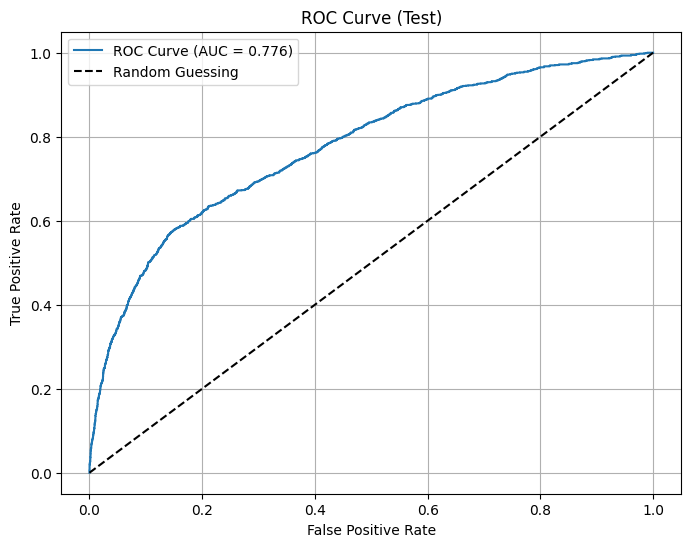

In [28]:
pipe_lasso_rf = Pipeline([
    ('prep', preprocessor),
    ('sel',  SelectFromModel(
                 LogisticRegression(penalty='l1',
                                    solver='saga',
                                    class_weight='balanced',
                                    max_iter=5000),
                 threshold='median',
                 max_features=30)),
    ('rf',   rf_base)
])

param_grid_lasso_rf = {
    # Lasso
    'sel__estimator__C':  np.logspace(-2, 1, 6),
    # Random Forest
    'rf__n_estimators':   [600, 800],
    'rf__max_depth':      [15, 20, 25],
    'rf__min_samples_leaf': [5, 10],
    'rf__max_features':   ['sqrt', 0.5]
}

search_lasso_rf = GridSearchCV(
    pipe_lasso_rf,
    param_grid_lasso_rf,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

search_lasso_rf.fit(X_train, y_train)
best_rf_sel = search_lasso_rf.best_estimator_

sel_step   = best_rf_sel.named_steps['sel']
prep_step  = best_rf_sel.named_steps['prep']

mask = sel_step.get_support()
feat = prep_step.get_feature_names_out()
print("Feature selected:", feat[mask])

print("Best parameters found:")
print(search_lasso_rf.best_params_)

evaluate(best_rf_sel, X_train, X_test, y_train, y_test,
         label="Random Forest - after Lasso")
evaluate_balanced(best_rf_sel, X_test, y_test)
plot_pr_auc(best_rf_sel, X_test, y_test, label="Test")
plot_auc_roc(best_rf_sel, X_test, y_test, label="Test")


## Plots

We put the two candidate pipelines, the full-feature Random Forest and the lean "RF + Lasso" version, through a final, side-by-side diagnostic:

1. **Balanced-accuracy bar chart:** we compute the metric on the held-out data and visualise it as a simple two-bar comparison. Both bars land at ≈ 0.71, confirming that the pruning step neither helps nor hurts class-balanced performance.

2. **Precision–recall overlay:** we score each model’s posterior probabilities, draw both PR curves on the same axes, and annotate the areas (PR-AUC ≈ 0.550 vs 0.553). The curves almost coincide; any advantage of the lasso-reduced model is at best marginal.

3. **ROC overlay:** we perform the same exercise for the ROC space. The two lines are virtually indistinguishable (AUC ≈ 0.774 vs 0.776), sitting well above the random-guess diagonal.

Taken together, these graphics let us **visually confirm** the quantitative verdict: eliminating half the features via lasso keeps the predictive power intact while giving us a lighter, more interpretable model.


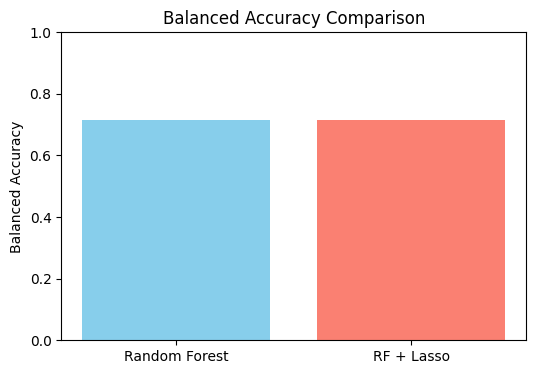

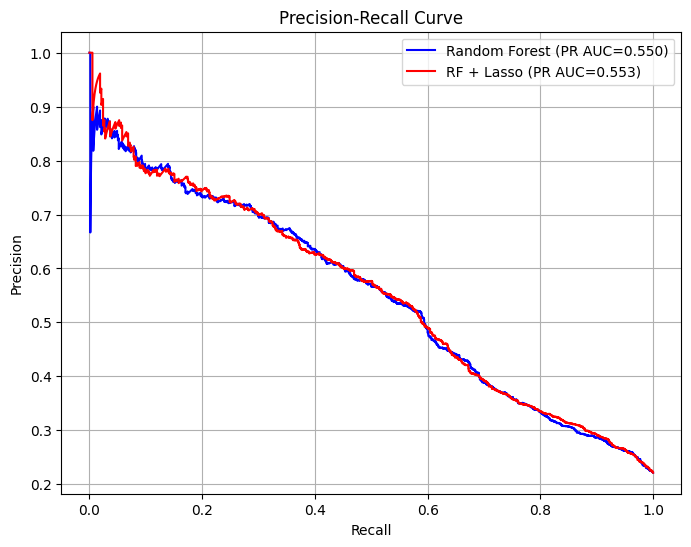

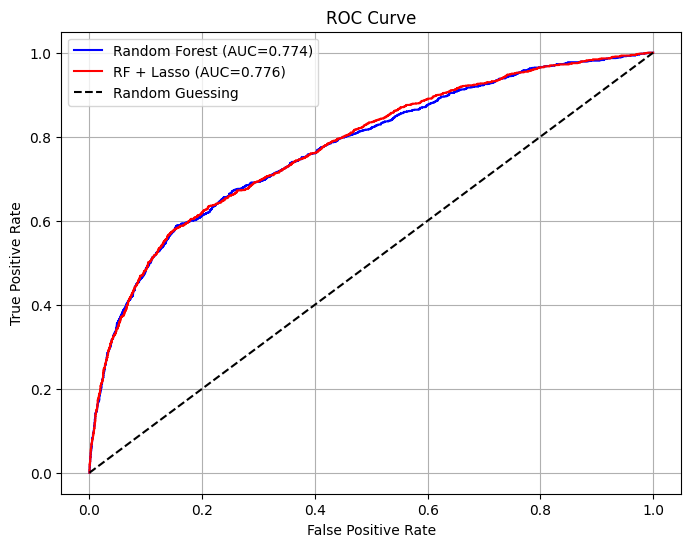

In [29]:
# Balanced Accuracy Bar Plot
bal_acc_rf = balanced_accuracy_score(y_test, best_rf.predict(X_test))
bal_acc_sel = balanced_accuracy_score(y_test, best_rf_sel.predict(X_test))

plt.figure(figsize=(6, 4))
plt.bar(['Random Forest', 'RF + Lasso'], [bal_acc_rf, bal_acc_sel], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Comparison')
plt.show()

# Precision-Recall Curve
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_proba_sel = best_rf_sel.predict_proba(X_test)[:, 1]
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)
prec_sel, rec_sel, _ = precision_recall_curve(y_test, y_proba_sel)
pr_auc_rf = average_precision_score(y_test, y_proba_rf)
pr_auc_sel = average_precision_score(y_test, y_proba_sel)

plt.figure(figsize=(8, 6))
plt.plot(rec_rf, prec_rf, label=f'Random Forest (PR AUC={pr_auc_rf:.3f})', color='blue')
plt.plot(rec_sel, prec_sel, label=f'RF + Lasso (PR AUC={pr_auc_sel:.3f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_sel, tpr_sel, _ = roc_curve(y_test, y_proba_sel)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_sel = auc(fpr_sel, tpr_sel)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.3f})', color='blue')
plt.plot(fpr_sel, tpr_sel, label=f'RF + Lasso (AUC={roc_auc_sel:.3f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

## Save the best model

We package the experiment for reuse: save both trained models, stash the exact test split, and record the Lasso-selected feature names, so anyone can reload, validate, or deploy the work without rerunning the notebook.

In [30]:
joblib.dump(best_rf,      MODEL_DIR / f"rf_full.joblib",   compress=3)
joblib.dump(best_rf_sel,  MODEL_DIR / f"rf_lasso.joblib",  compress=3)

print("\nModels saved in:", MODEL_DIR)

with open(MODEL_DIR / f"test_split.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

sel_mask = best_rf_sel.named_steps['sel'].get_support()
feat_all = best_rf_sel.named_steps['prep'].get_feature_names_out()
pickle.dump(feat_all[sel_mask], open(MODEL_DIR / f"rf_lasso_features.pkl", "wb"))


Models saved in: assets\models
